<a href="https://colab.research.google.com/github/mathewhall100/Histopathology-cancer-identification/blob/master/Histopathogy_cancer_cell_detection.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Kaggle Histopathology Cancer Cell Detection Challenge

### Introduction
Examination of lymph node tissue (obtained by biopsy or excision) for cancer cells is a common task for histopathologists. The aim of this competion was to create  a binary classifier that  distinguishes between the presence and absence  of metastatic tumour cells in histopathology slides of lymph node tissue.

### Data
The dataset is downloaded from Kaggle and formed part of their Histopathology Cancer Cell Detection competition. Images are 96 x 96 pixels but only the centremost 32 x 32 pixels were examined to label the image as either positive or negative for metastatic cancer. Identification by a trained pathologist of only a single cancer cell in the central 32 x 32 pixel area would result in the image being labelled positive  (1) for cancer cells. 

### Methods
Over 25000  images were used in training a resnet34 convolutional neural network (CNN) using the Fastai deep learning library. The outcome measure for the competition was the area under curve (AUC) of the receiver operator characteristic (ROC). ROC are probability curves which plot true positives against true negatives. The AUC-ROC is a meausre of the ability of the function or model to distinguish between the two classes and is a common metric for assessing binary medical tests.

### Results
The model achieved a 97% accuracy is correctly classifying histopathology images containing cancer cells vs those that conatined only normal lymph tissue cells. This corresponds to an AUC-ROC of 99.4% on the validation set. 

The kaggle competion had alraedy closed so this result could not be submitted, but it would have earned 10th place on the private leaderboard (out of 1157 entries) and 13th (out of 1157) on the public leaderboard.

## Notebook setup

In [0]:
from google.colab import drive
drive.mount("/content/gdrive", force_remount=True)
drive_dir = "/content/gdrive/My Drive/"

In [0]:
!pip install nbformat
!pip install nbconvert==5.4.1


In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Import libraries

In [0]:
import os
from pathlib import Path
from fastai.vision import *
from fastai.metrics import error_rate
import pandas as pd
from pandas import DataFrame
from sklearn.utils import shuffle
from sklearn.metrics import roc_auc_score

## Check GPU status

In [5]:
print("GPU: ", torch.cuda.is_available())
if torch.cuda.is_available() == True:
  print("Device = ", torch.device(torch.cuda.current_device()))
  print("PyTorch version - ", torch.__version__)
  print("Cuda version - ", torch.version.cuda)
  print("cuDNN version - ", torch.backends.cudnn.version())
print("python PIL version - ", PIL.PILLOW_VERSION)

GPU:  True
Device =  cuda:0
PyTorch version -  1.1.0
Cuda version -  10.0.130
cuDNN version -  7501
python PIL version -  4.3.0


## Download data 

In [0]:
import os # note - don't need this step if you have already imported fastai
!pip install kaggle
api_token = # {username and password copied exactly from the downloaded kaggle.json file}
import json
# Create .kaggle directory in /root if doesn't already exist
if not os.path.exists("/root/.kaggle"):
    os.mkdir("/root/.kaggle")
    print("Directory '/root/.kaggle' created ")
else:    
    print("Directory '/root/.kaggle' already exists")
# Create kaggle.json file in .kaggle directory and then write api_token into it
with open('/root/.kaggle/kaggle.json', 'w+') as file:
  json.dump(api_token, file)
# Important - change permissions of kaggle.json so your API credentials are not exposed to other users
!chmod 600 '/root/.kaggle/kaggle.json'

In [0]:
# Confirm that kaggle.json exists and contains API credentials
file = open('/root/.kaggle/kaggle.json', 'r')
print(file.read())

# Should print out your API credentials.

In [8]:
# Should be able to download kaggle dataset now using kaggle API
!kaggle competitions download -c histopathologic-cancer-detection

  0% 0.00/1.33M [00:00<?, ?B/s]
100% 1.33M/1.33M [00:00<00:00, 92.9MB/s]
  0% 0.00/5.10M [00:00<?, ?B/s]
100% 5.10M/5.10M [00:00<00:00, 83.1MB/s]
 99% 1.29G/1.30G [00:08<00:00, 133MB/s]
100% 1.30G/1.30G [00:09<00:00, 154MB/s]
100% 4.97G/4.98G [00:52<00:00, 36.9MB/s]
100% 4.98G/4.98G [00:52<00:00, 102MB/s] 


In [9]:
os.listdir()

['.config',
 'test.zip',
 'sample_submission.csv.zip',
 'gdrive',
 'train_labels.csv.zip',
 'train.zip',
 'sample_data']

In [10]:
# Unzip single files
!unzip 'train_labels.csv.zip'
!unzip 'sample_submission.csv.zip'

Archive:  train_labels.csv.zip
  inflating: train_labels.csv        
Archive:  sample_submission.csv.zip
  inflating: sample_submission.csv   


In [0]:
os.mkdir('test')
os.mkdir('train')

In [0]:
# Unzip folders with multiple images to new directories of same name
import zipfile

zip_ref = zipfile.ZipFile("test.zip")
target_dir = 'test'
zip_ref.extractall(target_dir)

zip_ref = zipfile.ZipFile("train.zip")
target_dir = 'train'
zip_ref.extractall(target_dir)

In [13]:
os.listdir()

['.config',
 'test.zip',
 'train',
 'test',
 'sample_submission.csv.zip',
 'sample_submission.csv',
 'gdrive',
 'train_labels.csv',
 'train_labels.csv.zip',
 'train.zip',
 'sample_data']

## helper functions

In [0]:
# auc_score
def auc_score(y_pred,y_true,tens=True):
    score=roc_auc_score(y_true,torch.sigmoid(y_pred)[:,1])
    if tens:
        score=tensor(score)
    else:
        score=score
    return score

In [0]:
# print single image with center box
def print_image(interp, i, row, idx, classes, probs):
  im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
  cl = int(cl)
  im = image2np(im.data)
  ax[row,i].imshow(im)
  ax[row,i].set_xticks([])
  ax[row,i].set_yticks([])
  box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
  ax[row,i].add_patch(box)
  ax[row,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {probs[idx]:.2f}')

In [0]:
# Print row of images
def print_row_images(label, text):
  for i, idx in enumerate(shuffled_data[shuffled_data['label'] == label]['id'][:5]):
      path = os.path.join(data_path_train, idx)
      img = plt.imread(path + '.tif')
      ax[label,i].imshow(img)
      # Create a Rectangle patch
      box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='b',facecolor='none', linestyle=':', capstyle='round')
      ax[label,i].add_patch(box)
  ax[label,0].set_ylabel(text, size='large', color='white')

## Define parameters

In [0]:
bs_resnet34 = 64
bs_resnet50 = 16
bs_densenet161 = 16
sz = 96
sz_small = 48

In [0]:
data_path = "/content/"
data_path_train = data_path + "train/"
data_path_test = data_path + "test/"

## Load  data

In [0]:
df_train = pd.read_csv(data_path + 'train_labels.csv')
df_test = pd.read_csv(data_path + 'sample_submission.csv')


In [22]:
labels = df_train['label'].value_counts()
label_neg = labels[0]
label_pos = labels[1]
             
print('Data Integrity Check')
print('---------------------------')
data = {"number images": [label_neg, label_pos],
        "percent": [round((label_neg/(label_neg+label_pos)*100), 2), round((label_pos/(label_neg+label_pos)*100), 2)]}
frame = pd.DataFrame(data, columns=["number images", "percent", ], index=["negative","positive"])
frame



Data Integrity Check
---------------------------


,number images,percent
negative,130908,59.5
positive,89117,40.5


In [23]:
df_train.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


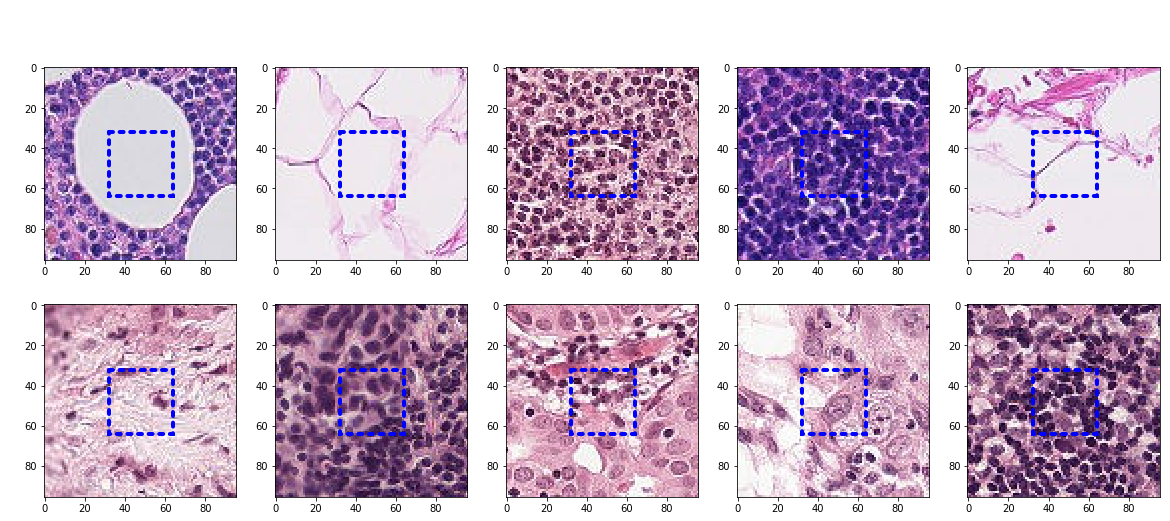

In [24]:
# plot a random sample of training images. 
# Note, only the center 32x32 pixels are used for labelling so we have highlighted these with a dashed box. 

shuffled_data = shuffle(df_train)

fig, ax = plt.subplots(2,5, figsize=(20,8))
fig.suptitle('Histopathologic scans of lymph node sections',fontsize=20, color='white')
print_row_images(0, 'Negative samples')
print_row_images(1, 'Tumor tissue samples')

## Create dataset

In [0]:
# Create dataset
# For data augmentation we can flip vertically as orientation doesn't matter to these images, but warp should = 0 as histopathology slides are always examined head on through a microscope
# Ensure reproducability validation set by setting random seed
random.seed(42)
test_img = ImageList.from_df(df_test, path=data_path, folder='test', suffix='.tif')
trfm = get_transforms(do_flip=True, flip_vert=True, max_rotate=10.0, max_zoom=1.1, max_lighting=0.2, max_warp=0.0, p_affine=0.75, p_lighting=0.75)
train_img = (ImageList.from_df(df_train, path=data_path, folder='train', suffix='.tif')
        .split_by_rand_pct(0.2)
        .label_from_df()
        .add_test(test_img)
        .transform(trfm, size=sz)
        .databunch(path='.', bs=bs_resnet34, device=torch.device('cuda:0'))
        .normalize(imagenet_stats)
       )

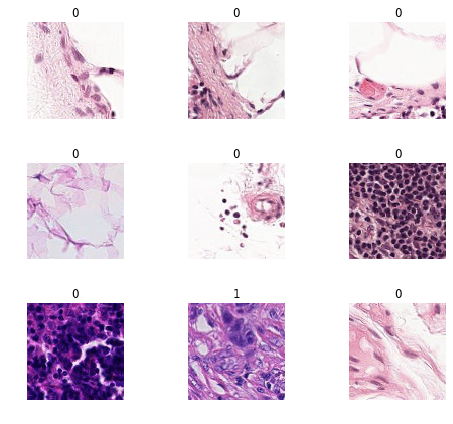

In [26]:
train_img.show_batch(rows=3, figsize=(7,6))

## Create learner

In [0]:
learn = cnn_learner(train_img, models.resnet34, metrics=[error_rate, accuracy, auc_score])
learn.model

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


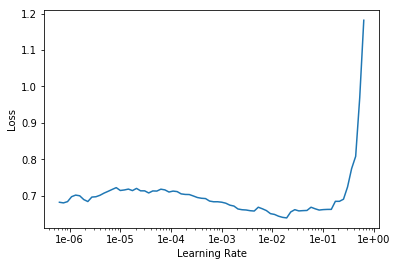

In [30]:
learn.lr_find()
learn.recorder.plot()

In [31]:
lr = 3e-03
learn.fit_one_cycle(5, slice(lr))

epoch,train_loss,valid_loss,error_rate,accuracy,auc_score,time
0,0.295372,0.269957,0.111442,0.888558,0.948785,07:42
1,0.236908,0.200801,0.076696,0.923304,0.972364,07:28
2,0.216327,0.182921,0.070651,0.929349,0.977314,07:24
3,0.206353,0.175260,0.066833,0.933167,0.979137,07:25
4,0.205115,0.175827,0.067265,0.932735,0.979365,07:24


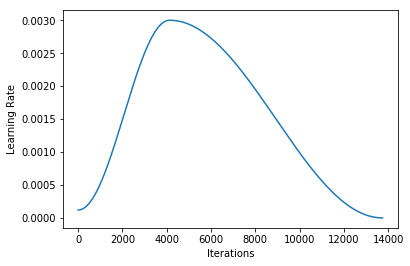

In [32]:
learn.recorder.plot_lr()

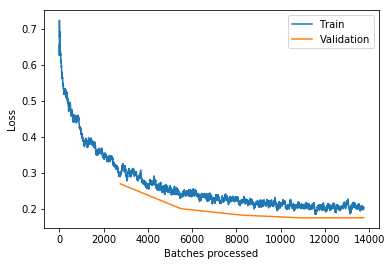

In [33]:
learn.recorder.plot_losses()

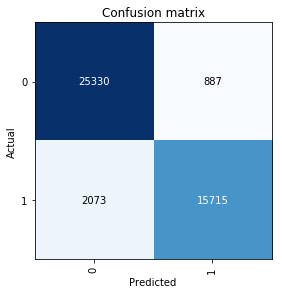

In [34]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title='Confusion matrix')

In [0]:
learn.save('base_model_rn34')

In [0]:
learn.load('base_model_rn34')

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


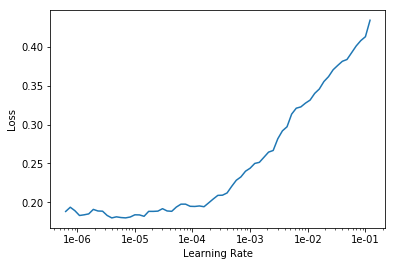

In [39]:
learn.unfreeze()
learn.lr_find()
learn.recorder.plot()

In [40]:
learn.fit_one_cycle(10, max_lr=slice(1e-5,lr/5))

epoch,train_loss,valid_loss,error_rate,accuracy,auc_score,time
0,0.191850,0.165998,0.063311,0.936689,0.981362,07:54
1,0.183353,0.153390,0.056266,0.943734,0.984268,07:54
2,0.142539,0.143775,0.053017,0.946983,0.986108,07:46
3,0.139657,0.124190,0.044836,0.955164,0.988923,07:49
4,0.147341,0.116543,0.040950,0.959050,0.990169,07:44
5,0.113421,0.106109,0.037359,0.962641,0.991865,07:41
6,0.112063,0.097725,0.033519,0.966481,0.993069,07:37
7,0.088294,0.091441,0.031928,0.968072,0.993835,07:33
8,0.079443,0.087362,0.029656,0.970344,0.994256,07:32
9,0.084611,0.088615,0.030678,0.969322,0.994272,07:35


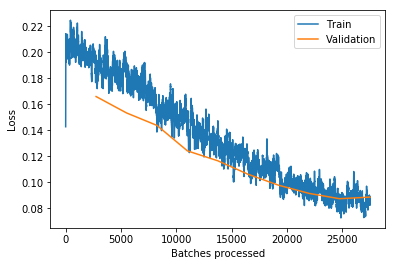

In [41]:
learn.recorder.plot_losses()

In [43]:
preds, y, loss = learn.get_preds(with_loss=True)
# get accuracy
acc = accuracy(preds, y)
print('The accuracy is {0} %.'.format(acc))

The accuracy is 0.9693216681480408 %.


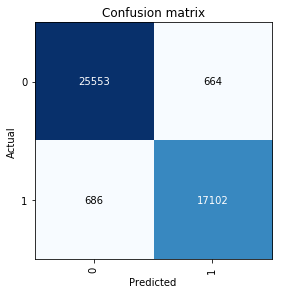

In [44]:
# predict the validation set with our model
interp = ClassificationInterpretation.from_learner(learn)
interp.plot_confusion_matrix(title='Confusion matrix')

In [0]:
# I modified this from the fastai's plot_top_losses (https://github.com/fastai/fastai/blob/master/fastai/vision/learner.py#L114)
from random import randint

def plot_overview(interp, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    probs = np.exp(preds[:,1])
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Predicted / Actual / Loss / Probability',fontsize=20, color='white')
    # Random           
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        im = image2np(im.data)
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
        ax[0,i].add_patch(box)
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {probs[idx]:.2f}', fontsize=10, color='white')
    ax[0,0].set_ylabel('Random samples', fontsize=16, color='white', rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[1,i].imshow(im)
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
        ax[1,i].add_patch(box)
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {probs[idx]:.2f}',  color='white')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, color='white', rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        im,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        im = image2np(im.data)
        ax[2,i].imshow(im)
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        box = patches.Rectangle((32,32),32,32,linewidth=4,edgecolor='r',facecolor='none', linestyle=':', capstyle='round')
        ax[2,i].add_patch(box)
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {probs[idx]:.2f}',  color='white')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, color='white', rotation=0, labelpad=80)

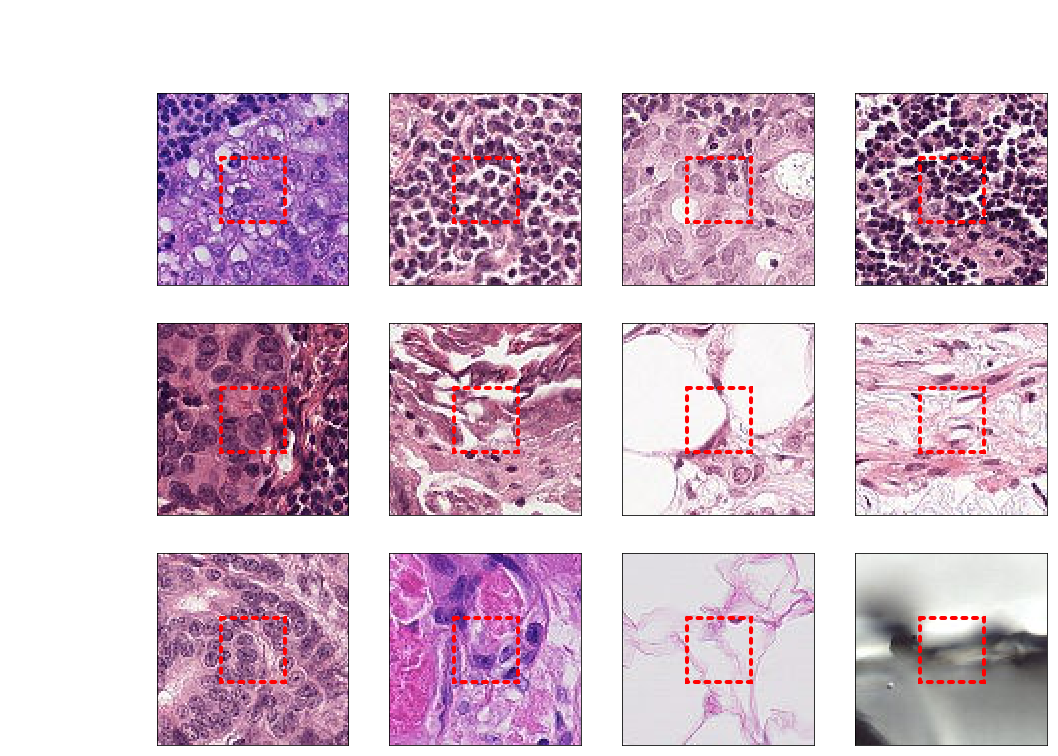

In [60]:
plot_overview(interp, ['Negative','Tumor'])


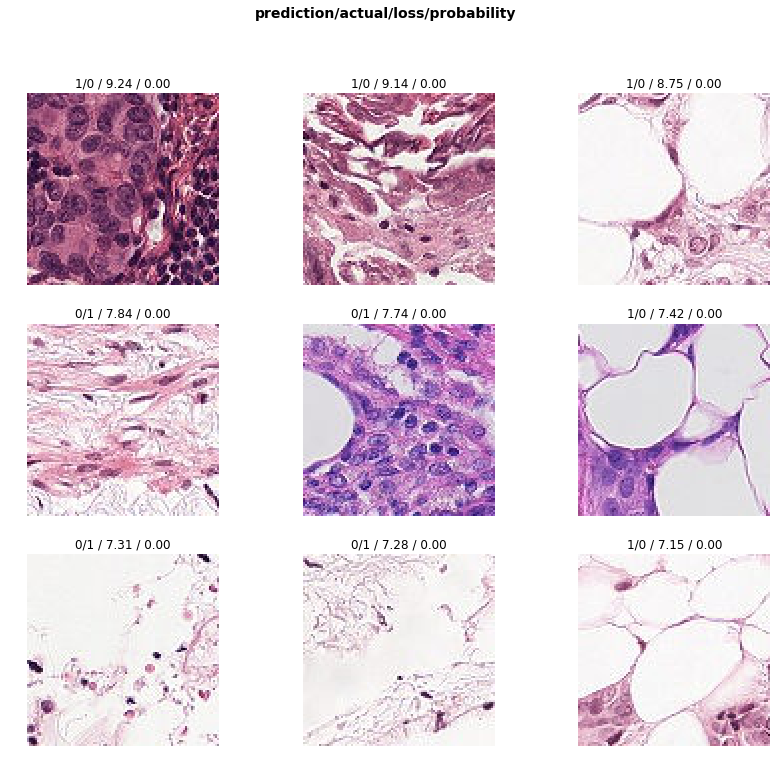

In [47]:
interp.plot_top_losses(9, figsize=(14,12))

In [0]:
learn.save('stage2_rn34')

In [0]:
from sklearn.metrics import roc_curve, auc
# probs from log preds
probs = np.exp(preds[:,1])
# Compute ROC curve
fpr, tpr, thresholds = roc_curve(y, probs, pos_label=1)


In [51]:
# Compute ROC area
roc_auc = auc(fpr, tpr)
print('ROC area is {0}'.format(roc_auc))

ROC area is 0.9943069016640526


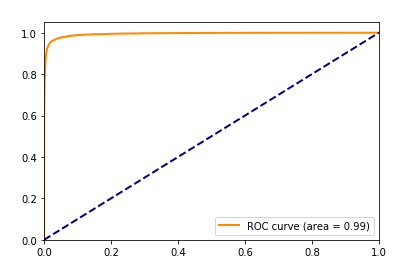

In [52]:
plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate', color='white')
plt.ylabel('True Positive Rate', color='white')
plt.title('Receiver operating characteristic example', color='white')
plt.legend(loc="lower right")
plt.show()